# Comparison of IV and CCH method on hippocampal data with optical stimulation of pyramidal neurons

Data kindly provided by Sam McKenzie and Daniel Fine English.

In [45]:
import numpy as np
import quantities as pq
import pandas as pd
import neo
import os
from itertools import chain
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import scipy
from method import IV
from tools_analysis import correlogram
import tools_experimentaldata as tls_exp
from tools_plot import savefig, fix_figure, set_style, despine, add_caption

In [2]:
# Load params
from params_experimentaldata import *

In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load into data into neo structure. 
Download it when necessary.
optoLabels.mat describes which files are optogenetically tagged (provided by Sam McKenzie).
Make sure that it is in data dir.
You may need to adjust data_dir in params_experimentaldata.py 

#### Create list of relevant files from optoLabels.mat


In [4]:
units_db = tls_exp.load_unitlabels('optoLabels.mat', '')
df_tmp = units_db.drop_duplicates(['animal', 'date'])
relevant_data = df_tmp.groupby('animal')['date'].apply(list).to_dict()

for animal_i in relevant_data.keys():
    for date_i in relevant_data[animal_i]:
        for entry in blk_blacklist:
            if animal_i == entry['animal'] and date_i == entry['date']:
                relevant_data[animal_i].remove(entry['date'])

In [5]:
print(relevant_data)

{'camkii2': ['20160421'], 'camkii3': ['20160504', '20160509', '20160510', '20160511', '20160518', '20160621', '20160506'], 'camkii4': ['20160815', '20160817', '20160823', '20160824'], 'camkii5': ['20160930', '20161004', '20160921']}


In [6]:
load_orig_files = True

if load_orig_files:
    tls_exp.download_files_by_dict(relevant_data,
                                   data_dir,
                                   n_shanks,
                                   files_ext_general,
                                   files_ext_by_shank,
                                   link_db)

    blks = tls_exp.create_neo_structure(relevant_data,
                                        data_dir,
                                        n_shanks,
                                        sampling_rate,
                                        unit_spiketime)

    tls_exp.add_stimulation_data_to_blocks(blks)
    tls_exp.annotate_units_from_db(units_db, blks)
    for blk in blks:
        animal = blk.annotations['animal']
        date = blk.annotations['date']
        if not os.path.exists(data_dir+ 'neo_files/'):
            os.makedirs(data_dir + 'neo_files/')

        nio = neo.io.PickleIO(data_dir + 'neo_files/' + animal + '_' + date + '.pckl')
        nio.write_block(blk)

else:
    blks = []
    for animal in relevant_data.keys():
        for date in relevant_data[animal]:
            nio = neo.io.PickleIO(data_dir + 'neo_files/' + animal + '_' + date + '.pckl')
            blk = nio.read_block()
            blks.append(blk)

/home/jovyan/work/instrumentalVariable/data/
Finished downloading
Neo structure created
Stimulation data added


## Consider only sessions containing pulse like stimulations

In [7]:
blks = tls_exp.select_blocks_upon_stimtype(blks,
    stimtype='pulse', min_intens=1)

/home/jovyan/work/instrumentalVariable/causal-optoconnectics/tools_experimentaldata.py:814: RuntimeWarning: invalid value encountered in greater_equal
  sel.append(epc.annotations['intensity'] >= min_intens)


## Determine which stimulations intensities have a significant effect  on units
We a) group very similar stimulations intensities and b) test whether intensity group has a significant effect on increasing spiking probability of any of the given units by convolving stimulation onsets with spike train.
We use the activity before a stimulation as baseline.


In [8]:
blks = tls_exp.group_stimulations(blks,
                                  sep_bins,
                                  sep_kernel_width,
                                  sep_threshold)

In [9]:
df_stim = tls_exp.find_significant_stimulations(blks,
   stimccg_binsize,
   stimccg_limit,
   stimccg_pthres,
   condition_annot_unit={'tagged': True})

  0%|          | 0/53 [00:00<?, ?it/s]

camkii4 20160817
Shank: 1
Shank: 3
camkii4 20160823
Shank: 3
Group: 0 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 1 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 2 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 3 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 4 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Shank: 4
Group: 0 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 1 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 2 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 3 of 5


  0%|          | 0/53 [00:00<?, ?it/s]

Group: 4 of 5


  0%|          | 0/51 [00:00<?, ?it/s]

camkii4 20160824
Shank: 1
Shank: 2
Shank: 4
Group: 0 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 1 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 2 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 3 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 4 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 5 of 7


  0%|          | 0/51 [00:00<?, ?it/s]

Group: 6 of 7


  0%|          | 0/40 [00:00<?, ?it/s]

camkii5 20160930
Shank: 1
Group: 0 of 1


  0%|          | 0/40 [00:00<?, ?it/s]

Shank: 2
Group: 0 of 1


  0%|          | 0/25 [00:00<?, ?it/s]

camkii5 20161004
Shank: 1
Group: 0 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 1 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 2 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 3 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 4 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 5 of 6


  0%|          | 0/25 [00:00<?, ?it/s]

Shank: 2
Group: 0 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 1 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 2 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 3 of 5


  0%|          | 0/25 [00:00<?, ?it/s]

Group: 4 of 5


100%|██████████| 16/16 [00:00<00:00, 42393.47it/s]

camkii5 20160921
Shank: 4
Group: 0 of 5
Group: 1 of 5
Group: 2 of 5
Group: 3 of 5
Group: 4 of 5


### Example plot of  stimulation response

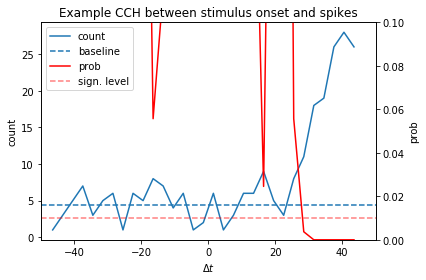

In [10]:
fig, ax = plt.subplots(1)
row_sel = 2
ln0 = ax.plot(df_stim.loc[row_sel]['bins'],
        df_stim.loc[row_sel]['cch'],
       label='count')
ln1 = ax.axhline(df_stim.loc[row_sel]['rate_baseline'],
           label='baseline',
          linestyle='--')
ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel(r'count')
ax2 = ax.twinx()
ln2 = ax2.plot(df_stim.loc[row_sel]['bins'],
         df_stim.loc[row_sel]['pfast'], c='r',
        label='prob')
ln3 = ax2.axhline(stimccg_pthres, c='r', linestyle='--',alpha=0.5, label='sign. level')
ax2.set_ylabel(r'prob')

ax2.set_ylim(0, 0.1)
ax.set_xlim(-50., 50.)
ax2.set_xlim(-50., 50.)

ln = ln0+[ln1]+ln2+[ln3]
labs = [l.get_label() for l in ln]
ax.legend(ln, labs, loc=0)
ax.set_title('Example CCH between stimulus onset and spikes')
plt.show()

## Overview of stimulation intensities
For each unit, we show the strongest available stimulation.

In [11]:
group_obj = df_stim.groupby(['animal', 'date', 'shank_unit', 'cluster', 'shank_stim'])
idxmax = group_obj['intens_mean'].idxmax()
idxmin = group_obj['intens_mean'].idxmin()

In [12]:
group_obj['intens_mean'].max()

animal   date      shank_unit  cluster  shank_stim
camkii4  20160823  3.0         3.0      3.0           2203.590048
                                        4.0           2165.124239
                               4.0      3.0           2203.590048
                                        4.0           2165.124239
                               5.0      3.0           2203.590048
                                        4.0           2165.124239
                               7.0      3.0           2203.590048
                                        4.0           2165.124239
                               10.0     3.0           2203.590048
                                        4.0           2165.124239
                               13.0     3.0           2203.590048
                                        4.0           2165.124239
                               14.0     3.0           2203.590048
                                        4.0           2165.124239
                         

## Response time by stimulation intensity
We visualize the time it takes for units to show a significant increase in spiking probability for maximal stimulation intensities on same shank vs other shanks.
The last bin, $\Delta t = 25$ ms, includes also larger times

In [13]:
t_max_same = []
t_max_diff = []
intens_max_same =[]
intens_max_diff =[]
for i in idxmax:
    if df_stim.loc[i]['shank_stim'] == df_stim.loc[i]['shank_unit']:
        t_max_same.append(df_stim.loc[i]['first_bin_sig'])
        intens_max_same.append(df_stim.loc[i]['intens_mean'])
    if df_stim.loc[i]['shank_stim'] != df_stim.loc[i]['shank_unit']:
        t_max_diff.append(df_stim.loc[i]['first_bin_sig'])
        intens_max_diff.append(df_stim.loc[i]['intens_mean'])
t_max_same = np.array(t_max_same)
t_max_diff = np.array(t_max_diff)

In [14]:
t_min_same = []
t_min_diff = []
intens_min_same =[]
intens_min_diff =[]
for i in idxmin:
    if df_stim.loc[i]['shank_stim'] == df_stim.loc[i]['shank_unit']:
        t_min_same.append(df_stim.loc[i]['first_bin_sig'])
        intens_min_same.append(df_stim.loc[i]['intens_mean'])
    if df_stim.loc[i]['shank_stim'] != df_stim.loc[i]['shank_unit']:
        t_min_diff.append(df_stim.loc[i]['first_bin_sig'])
        intens_min_diff.append(df_stim.loc[i]['intens_mean'])
t_min_same = np.array(t_min_same)
t_min_diff = np.array(t_min_diff)

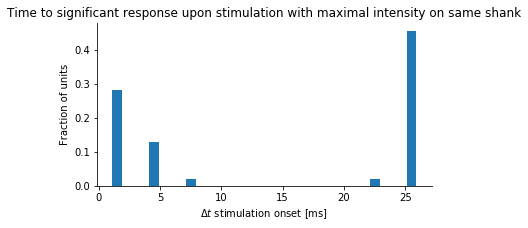

In [15]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
bins = np.arange(1.5, 31.5, 3)
hist, bins = np.histogram(t_max_same, bins)
hist = hist / len(t_max_same)
ax.bar(bins[:-1], hist)
despine(ax)
ax.set_title('Time to significant response upon stimulation with maximal intensity on same shank')
ax.set_xlabel(r'$\Delta t$ stimulation onset [ms]')
ax.set_ylabel('Fraction of units')
plt.show()

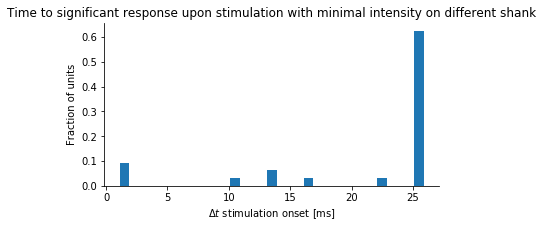

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,3))
bins = np.arange(1.5, 31.5, 3)
hist, bins = np.histogram(t_min_diff, bins)
hist = hist / len(t_min_diff)
ax.bar(bins[:-1], hist)
despine(ax)
ax.set_title('Time to significant response upon stimulation with minimal intensity on different shank')
ax.set_xlabel(r'$\Delta t$ stimulation onset [ms]')
ax.set_ylabel('Fraction of units')
plt.show()

#### Observation
Stimulation on a different shank leads only in very few cases to a significant reaction in a reasonable time frame.

## Calculate IV
We calculate the wald estimate for those stimulations that show a significant response within the IV window.

In [17]:
windw = iv_window.rescale(df_stim['first_bin_sig'].values[0].units).magnitude[np.newaxis][0]
df_sigstim = df_stim[df_stim['first_bin_sig'] <= windw]

In [18]:
df_sigstim['intens_mean'] = df_sigstim['intens_mean'].astype(int)
group_sigstim = df_sigstim.groupby(['animal', 'date', 'shank_unit', 'cluster', 'shank_stim'])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
calc_cch_iv = True
if not calc_cch_iv:
    df_cch = pd.read_pickle('results/df_cch.pckl')
if calc_cch_iv:
    df_iv = tls_exp.calculate_iv(
        blks,
        df_sigstim,
        iv_min_n_stim,
        iv_window,
        iv_ltnc,
        condition_annot_pre={'tagged': True},
        condition_annot_post={'tagged': False})

camkii4: 20160817
camkii4: 20160823
camkii4: 20160824
camkii5: 20160930
camkii5: 20161004
camkii5: 20160921


### Calculate CCH estimate
We calculate the so called transmission probability, the CCH estimate of synaptic coupling.

In [20]:
if calc_cch_iv:
    df_cch_all = tls_exp.calculate_transmission_prob(
        blks,
        ccg_time_limit,
        ccg_binsize,
        ccg_hollow_fraction,
        ccg_width,
        ccg_sig_level_causal,
        ccg_sig_level_fast,
        ccg_peak_wndw,
        condition_annot_pre={'tagged': True},
        condition_annot_post={'tagged': False})
    df_cch_all.rename(columns={'transprob': 'transproball',
                                'bool_cnnctd': 'boolcnnctdall'}, inplace=True)
    df_cch = pd.merge(df_iv, df_cch_all,
    on=['animal','date',
        'shank_pre', 'cluster_pre',
       'shank_post','cluster_post'])
    df_cch.to_pickle('results/df_cch.pckl')

camkii4: 20160817
camkii4: 20160823
camkii4: 20160824
camkii5: 20160930
camkii5: 20161004
camkii5: 20160921


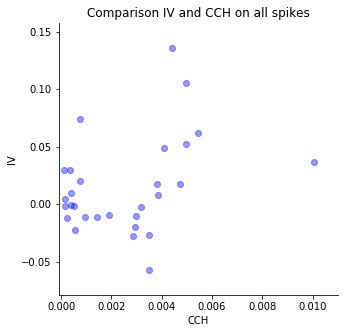

In [21]:
fig, ax = plt.subplots(1, figsize=(5,5))

#ax.set(xscale="log", yscale="log")

ax.scatter(df_cch.loc[df_cch['boolcnnctdall']==True]['transproball'],
           df_cch.loc[df_cch['boolcnnctdall']==True]['ivwald'],
          c='b',
          alpha=0.4)
#ax.scatter(df_cch['transproball'],
#           df_cch['ivwald'],
#          c='r',
#          alpha=0.1)
ax.set_xlabel(r'CCH')
ax.set_ylabel(r'IV')
ax.set_xlim([-0.0001, 0.011])
#ax.set_ylim([-0.03, 0.125])
despine(ax)
ax.set_title('Comparison IV and CCH on all spikes')
plt.show()
fig.tight_layout(rect=[0, 0.00, 1, 1])
#fig.savefig('manuscript/Optodata_comparisonIV_CCH.svg')


### Number of units used for analysis 

In [22]:
group_df_pre = df_cch[
    ['animal', 'date', 'shank_pre', 'cluster_pre']
].groupby(['animal', 'date', 'shank_pre']).nunique()
print('Number of presynaptic units (cluster_pre) by animal, date and shank')
print(group_df_pre)

Number of presynaptic units (cluster_pre) by animal, date and shank
                            animal  date  shank_pre  cluster_pre
animal  date     shank_pre                                      
camkii4 20160823 3               1     1          1            1
                 4               1     1          1            1
        20160824 4               1     1          1           14
camkii5 20161004 2               1     1          1            1


In [23]:
group_df_post = df_cch[
    ['animal', 'date', 'shank_post', 'cluster_post']
].groupby(
    ['animal', 'date', 'shank_post']).nunique()
print('Number of postsynaptic units (cluster_post) by animal, date and shank')
print(group_df_post)

Number of postsynaptic units (cluster_post) by animal, date and shank
                             animal  date  shank_post  cluster_post
animal  date     shank_post                                        
camkii4 20160823 1                1     1           1             3
                 2                1     1           1             5
                 3                1     1           1            15
                 4                1     1           1             5
        20160824 1                1     1           1             2
                 2                1     1           1             5
                 3                1     1           1            26
                 4                1     1           1             4
camkii5 20161004 1                1     1           1            11
                 2                1     1           1             9
                 3                1     1           1             1


### Intensities that satisfied criterium

In [24]:
#with open('session_expdata.tex','w') as tf:
#    tf.write(group_sigstim['intens_mean'].unique().to_latex())
group_sigstim['intens_mean'].unique()

animal   date      shank_unit  cluster  shank_stim
camkii4  20160823  3.0         15.0     4.0                                         [2063]
                               18.0     3.0                                         [2203]
                               21.0     3.0                                         [2062]
                               22.0     3.0                                         [2203]
                               28.0     3.0                                   [1775, 1922]
                   4.0         6.0      3.0                                         [1775]
                                        4.0                                         [2165]
                               10.0     4.0                                         [1784]
                               11.0     4.0                                         [1895]
         20160824  4.0         2.0      4.0           [2048, 2084, 2124, 2188, 2266, 2333]
                               6.0     

### Autocorrelation of presynaptic units
Because of slow stimulation onset we used a relatively long iv window.
We want to see how this compares to the refractory period of pyramidal cells.

In [25]:
autocorr_dict = {}
units_pre = df_cch.loc[df_cch['boolcnnctdall']==True].groupby(
    ['animal', 'date', 'shank_pre', 'cluster_pre']
).apply(list).to_dict()
for animal, date, shank_pre, cluster_pre in units_pre.keys():
    for blk in blks:
        units = blk.channel_indexes[0].children
        if blk.annotations['date'] == date and blk.annotations['animal'] == animal:
            unit_i = [unit for unit in units if
                      unit.annotations['shank'] == shank_pre and
                      unit.annotations['cluster'] == cluster_pre][0]
            spktr=unit_i.spiketrains[0]
            cnt, bins_autocorr = correlogram(
                spktr, auto=True,
                limit=autocorr_limit,
                binsize=autocorr_binsize,
                density=True)
            autocorr_dict[animal + '_' + date + '_' 
                          +str(shank_pre) +'_'+ str(cluster_pre)] = cnt

In [26]:
autocorr = np.array(list(chain(autocorr_dict.values())))

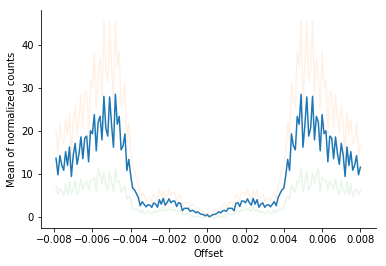

In [27]:
fig, ax = plt.subplots(1)
autocorr_mean = np.mean(autocorr, axis=0)
autocorr_std = np.std(autocorr, axis=0)

ax.plot(bins_autocorr, autocorr_mean)
ax.plot(bins_autocorr, autocorr_mean+autocorr_std, alpha=0.1)
ax.plot(bins_autocorr, autocorr_mean-autocorr_std, alpha=0.1)

ax.set_ylabel(r'Mean of normalized counts')
ax.set_xlabel(r'Offset')
despine(ax)
savefig(fig, fname='Optodata_autocorrelation.svg')

### Observation
The average of the scaled autocorrelogram indicates a refractory period of around $4$ ms.

## Bootstrapping
To test the uncertainty of each IV and CCH estimate, we perform bootstrapping with a sample size of $1000$

#### CCH
We use the additive property of the cross correlation function.
We calculate the CCH on chunks of spike trains.
We then randomly pick chunks with replacement, add them up and perform CCH estimation.


In [30]:
# Consider only significant connections
# for bootstrapping
conns_sel = list(
    df_cch.loc[df_cch['boolcnnctdall']==True].groupby(
    ['animal', 'date', 'shank_pre', 'cluster_pre', 'shank_post', 'cluster_post']
    ).apply(list).to_dict())

In [40]:
calculate_df_btstrp_cch = True

if calculate_df_btstrp_cch:
    df_btstrp_cch = tls_exp.bootstrap_cch(
            blks, btstrp_n,
            btstrp_binsize,                                                                                                                                                                                            
            ccg_binsize,                                                                                                                                                                                               
            ccg_hollow_fraction,                                                                                                                                                                                       
            ccg_peak_wndw,                                                                                                                                                                                             
            ccg_time_limit,
            ccg_width,
            conns_sel=conns_sel)
    df_btstrp_cch.to_pickle('results/df_btstrp_cch.pckl')
else:
    df_btstrp_cch = pd.read_pickle('results/df_btstrp_cch.pckl')



  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [01:49<50:54, 109.09s/it]

  7%|▋         | 2/29 [03:55<51:29, 114.42s/it]

 10%|█         | 3/29 [06:34<55:19, 127.67s/it]

 14%|█▍        | 4/29 [11:13<1:12:03, 172.95s/it]

 17%|█▋        | 5/29 [17:21<1:32:41, 231.72s/it]

 21%|██        | 6/29 [35:51<3:09:47, 495.10s/it]

 24%|██▍       | 7/29 [49:14<3:35:24, 587.49s/it]

 28%|██▊       | 8/29 [54:31<2:57:09, 506.18s/it]

 31%|███       | 9/29 [56:56<2:12:40, 398.00s/it]

 34%|███▍      | 10/29 [1:05:06<2:14:44, 425.48s/it]

 38%|███▊      | 11/29 [1:06:35<1:37:21, 324.51s/it]

 41%|████▏     | 12/29 [1:12:27<1:34:15, 332.68s/it]

 45%|████▍     | 13/29 [1:14:05<1:09:58, 262.38s/it]

 48%|████▊     | 14/29 [1:18:01<1:03:36, 254.40s/it]

 52%|█████▏    | 15/29 [1:25:56<1:14:50, 320.77s/it]

 55%|█████▌    | 16/29 [1:51:02<2:26:31, 676.24s/it]

 59%|█████▊    | 17/29 [1:58:54<2:03:00, 615.01s/it]

 62%|██████▏   | 18/29 [2:01:47<1:28:26, 482.42s/it]

 66%|██████▌   | 19

#### IV
We first find all onsets and classify whether they contain a spike or not.
Then we randomly pick onsets with replacement.

In [41]:
calculate_df_btstrp_iv = True

if calculate_df_btstrp_iv:
    df_btstrp_iv = tls_exp.bootstrap_iv(
            blks, btstrp_n,                                                                                                                                                                                                   
            df_sigstim,                                                                                                                                                                                                
            iv_min_n_stim,                                                                                                                                                                                             
            iv_window,                                                                                                                                                                                                 
            iv_ltnc,                                                                                                                                                                                                   
            conns_sel=conns_sel)
    df_btstrp_iv.to_pickle('results/df_btstrp_iv.pckl')
else:
    df_btstrp_iv = pd.read_pickle('results/df_btstrp_iv.pckl')



  0%|          | 0/29 [00:00<?, ?it/s]/home/jovyan/work/instrumentalVariable/causal-optoconnectics/tools_experimentaldata.py:1339: RuntimeWarning: Mean of empty slice.
  wald = ys_i.mean() - ysr_i.mean()
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  3%|▎         | 1/29 [00:03<01:33,  3.34s/it]

  7%|▋         | 2/29 [00:06<01:30,  3.36s/it]

 10%|█         | 3/29 [00:10<01:28,  3.41s/it]

 14%|█▍        | 4/29 [00:13<01:27,  3.48s/it]

 17%|█▋        | 5/29 [00:17<01:25,  3.56s/it]

 21%|██        | 6/29 [00:21<01:23,  3.64s/it]

 24%|██▍       | 7/29 [00:25<01:22,  3.73s/it]

 28%|██▊       | 8/29 [00:29<01:21,  3.87s/it]

 31%|███       | 9/29 [00:33<01:19,  4.00s/it]

 34%|███▍      | 10/29 [00:38<01:18,  4.12s/it]

 38%|███▊      | 11/29 [00:42<01:16,  4.25s/it]

 41%|████▏     | 12/29 [00:47<01:14,  4.39s/it]

 45%|████▍     | 13/29 [00:52<01:11,  4.50s/it]

 

In [42]:
CI = 95.
perc_low = (100-CI)/2
perc_high = 100 - perc_low

cch_err_low = []
cch_err_high = []

iv_err_low = []
iv_err_high = []

iv_med = []
cch_med = []

for conn in conns_sel:
    (animal,
     date,
     shank_pre,
     cluster_pre,
     shank_post,
     cluster_post) = conn
    df_conn_iv = df_btstrp_iv.loc[
        (df_btstrp_iv['animal'] == animal) &
        (df_btstrp_iv['date'] == date) &
        (df_btstrp_iv['shank_pre'] == shank_pre) &
        (df_btstrp_iv['cluster_pre'] == cluster_pre) &
        (df_btstrp_iv['shank_post'] == shank_post) &
        (df_btstrp_iv['cluster_post'] == cluster_post)]
    med = np.nanmedian(df_conn_iv['ivwald'])
    err_low = med-np.nanpercentile(df_conn_iv['ivwald'], perc_low)
    err_high = np.nanpercentile(df_conn_iv['ivwald'], perc_high)-med
    iv_med.append(med)
    iv_err_low.append(err_low)
    iv_err_high.append(err_high)


    df_conn_cch = df_btstrp_cch.loc[
        (df_btstrp_cch['animal'] == animal) &
        (df_btstrp_cch['date'] == date) &
        (df_btstrp_cch['shank_pre'] == shank_pre) &
        (df_btstrp_cch['cluster_pre'] == cluster_pre) &
        (df_btstrp_cch['shank_post'] == shank_post) &
        (df_btstrp_cch['cluster_post'] == cluster_post)]
    med = np.nanmedian(df_conn_cch['trans_prob'])
    err_low = med-np.nanpercentile(df_conn_cch['trans_prob'], perc_low)
    err_high = np.nanpercentile(df_conn_cch['trans_prob'], perc_high)-med
    
    cch_err_low.append(err_low)
    cch_err_high.append(err_high)    
    cch_med.append(med)
    
iv_err = np.vstack([iv_err_low, iv_err_high])
iv_med = np.array(iv_med)
cch_err = np.vstack([cch_err_low, cch_err_high])
cch_med = np.array(cch_med)

In [43]:
# fit linear model on median values
m, b = np.polyfit(cch_med, iv_med, 1)
f_lin = lambda x: m*x+b

In [46]:
scipy.stats.pearsonr(cch_med, iv_med)

(0.3385059927339961, 0.07246654559063853)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


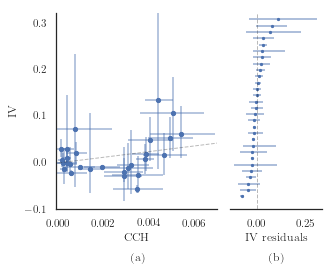

In [47]:
# we rescale iv_values for visualization
set_style('article', h=2.)
fig = plt.figure()
gs0 = GridSpec(4, 8, wspace=.55)
ax1 = fig.add_subplot(gs0[:, 0:5])
ax2 = fig.add_subplot(gs0[:, 5:])

ax1.scatter(cch_med,
           iv_med,
           c='b',
           alpha=1,
           s=18)
ax1.errorbar(cch_med,
            iv_med,
            xerr=cch_err,
            yerr=iv_err,
            fmt='None',
            ecolor='b',
            alpha=0.4)
ax1.set_xlabel(r'CCH')
ax1.set_ylabel(r'IV')
ax1.set_xlim([-0.0001, 0.007])
#ax.set_xlim([-0.0001, 0.01])
ax1.set_ylim([-0.1, 0.32])
ax1.plot([0, 1],
         [f_lin(0), f_lin(1)],
         'k--', alpha=0.3,
        linewidth=1.)

despine(ax=ax1)

cch_argsort = np.argsort(cch_med)
ids = np.arange(0, len(cch_med),1)



rsdl_iv = iv_med - f_lin(cch_med)
argsortd = np.argsort(rsdl_iv)

ax2.scatter(rsdl_iv[argsortd],
            ids,
            s=5,
            c='b')
ax2.errorbar(rsdl_iv[argsortd],
             ids,
             xerr=iv_err[:, argsortd],
             ecolor='b',
             fmt='None',
             capsize=0,
             elinewidth=1.5,
             alpha=0.6)
ax2.plot([0, 0], [-100,100], 'k--', alpha=0.3, linewidth=1.)
#ax2.plot(-100,-100, 'b', label=r'CCH')
#ax2.plot(-100,-100, 'r', label=r'IV $[10^{-1}]$')
#ax2.legend(loc='lower right')
ax2.set_xlabel(r'IV residuals')
#ax2.set_xlim([-0.01, 0.025])
ax2.set_ylim([-2, len(cch_med)+0.])
ax2.set_yticks([], [])

despine(ax=ax2, left=True)
add_caption([ax1, ax2], start='a')

fig.tight_layout()
fig.subplots_adjust(left=0.16, bottom=0.2)
fig.savefig('manuscript/Optodata_comparison_IvCch.svg', dpi=180)
